<a href="https://colab.research.google.com/github/Sowmyad15/SMS_Spam/blob/main/Unsupervised_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from transformers import BertTokenizer, BertModel
from sklearn.metrics import silhouette_score


In [ ]:
df=pd.read_csv('/content/spam.csv',encoding='latin-1')
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [ ]:
df = df.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
df.columns = ["label", "message"]
df['label_num']=df['label'].map({
    'ham':0,
    'spam':1
})
df.head()

,label,message,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [ ]:
import spacy

nlp = spacy.load("en_core_web_sm")

def preprocess(text):
    # remove stop words and lemmatize the text
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)

    return " ".join(filtered_tokens)
df['preprocessed_txt'] = df['message'].apply(preprocess)
df.head()

,label,message,label_num,preprocessed_txt
0,ham,"Go until jurong point, crazy.. Available only ...",0,jurong point crazy available bugis n great wor...
1,ham,Ok lar... Joking wif u oni...,0,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry 2 wkly comp win FA Cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,0,u dun early hor u c
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,nah think go usf live


In [ ]:
import torch
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
def get_bert_embedding(text):
    tokens = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        output = model(**tokens.to(device))
    embeddings = output.last_hidden_state.mean(dim=1).cpu().numpy()
    return embeddings


In [ ]:
df['bert_embedding'] = df['preprocessed_txt'].apply(get_bert_embedding)


In [ ]:
X = np.vstack(df['bert_embedding'].to_numpy())

In [ ]:
X

array([[-5.23086973e-02, -5.26819408e-01,  6.00303173e-01, ...,
        -1.68078281e-02,  7.96578377e-02,  6.67725503e-03],
       [ 1.34806037e-02, -6.25014454e-02,  4.68337506e-01, ...,
        -1.98317170e-01, -3.54611754e-01,  2.51734793e-01],
       [ 6.96029514e-02, -2.23868527e-02,  6.79387331e-01, ...,
        -5.75951114e-02, -6.46834001e-02,  2.88564831e-01],
       ...,
       [ 6.38745204e-02,  7.54342088e-03, -4.30002473e-02, ...,
         3.28168385e-02, -3.16936523e-01, -7.62076154e-02],
       [ 4.56439584e-01, -2.78951943e-01,  3.98768902e-01, ...,
        -2.32835174e-01, -2.25325763e-01, -1.31051004e-01],
       [-3.73822462e-04, -2.98148245e-01, -2.55075693e-01, ...,
         1.37871608e-01,  1.05675243e-01, -1.22211814e-01]], dtype=float32)

In [ ]:
len(X[0])

768

In [ ]:
len(X)

5572

In [ ]:
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(X)

In [ ]:
reduced_embeddings

array([[-2.0109406 , -0.07565977],
       [-1.5617353 ,  2.9088666 ],
       [-2.5629964 , -2.9366417 ],
       ...,
       [ 3.3601725 , -0.50363797],
       [-1.0824466 ,  0.42892775],
       [ 3.99771   , -1.123614  ]], dtype=float32)

In [ ]:
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=42)
kmeans.fit(reduced_embeddings)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2, random_state=42)

In [ ]:
cluster_labels = kmeans.labels_

In [ ]:
cluster_labels

array([0, 0, 0, ..., 1, 0, 1], dtype=int32)

In [ ]:
silhouette_avg = silhouette_score(reduced_embeddings, cluster_labels)

In [ ]:
for i, label in enumerate(cluster_labels):
    print(f"SMS: {df['message'][i]} - Cluster: {label}")


Streaming output truncated to the last 5000 lines.
SMS: Can you open the door? - Cluster: 1
SMS: Waiting for your call. - Cluster: 1
SMS: Nope i waiting in sch 4 daddy...  - Cluster: 0
SMS: You have won ?1,000 cash or a ?2,000 prize! To claim, call09050000327 - Cluster: 0
SMS: I'm tired of arguing with you about this week after week. Do what you want and from now on, i'll do the same. - Cluster: 1
SMS: ÌÏ wait 4 me in sch i finish ard 5.. - Cluster: 0
SMS: our mobile number has won å£5000, to claim calls us back or ring the claims hot line on 09050005321. - Cluster: 0
SMS: Arngd marriage is while u r walkin unfortuntly a snake bites u. bt love marriage is dancing in frnt of d snake &amp; sayin Bite me, bite me. - Cluster: 0
SMS: Huh so early.. Then Ì_ having dinner outside izzit? - Cluster: 0
SMS: Ok anyway no need to change with what you said - Cluster: 1
SMS: We tried to contact you re your reply to our offer of 750 mins 150 textand a new video phone call 08002988890 now or reply for

In [ ]:
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.411073237657547


In [ ]:
df['cluster']=kmeans.labels_

In [ ]:
df

,label,message,label_num,preprocessed_txt,bert_embedding,cluster
0,ham,"Go until jurong point, crazy.. Available only ...",0,jurong point crazy available bugis n great wor...,"[[-0.052308697, -0.5268194, 0.6003032, 0.06971...",0
1,ham,Ok lar... Joking wif u oni...,0,ok lar joke wif u oni,"[[0.013480604, -0.062501445, 0.4683375, -0.614...",0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry 2 wkly comp win FA Cup final tkts 2...,"[[0.06960295, -0.022386853, 0.67938733, -0.242...",0
3,ham,U dun say so early hor... U c already then say...,0,u dun early hor u c,"[[-0.27300587, 0.29489645, 0.04042073, -0.3732...",0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,nah think go usf live,"[[-0.0017658919, -0.041766174, 0.8399235, 0.02...",0
...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,1,2nd time try 2 contact u. U win å£750 Pound pr...,"[[0.075172804, 0.11247507, 0.6669232, -0.61304...",0
5568,ham,Will Ì_ b going to esplanade fr home?,0,Ì b go esplanade fr home,"[[0.1327893, -0.13852346, 0.8855592, -0.125763...",0
5569,ham,"Pity, * was in mood for that. So...any other s...",0,pity mood suggestion,"[[0.06387452, 0.007543421, -0.043000247, 0.079...",1
5570,ham,The guy did some bitching but I acted like i'd...,0,guy bitching act like interested buy week give...,"[[0.45643958, -0.27895194, 0.3987689, -0.24852...",0


<ipython-input-22-7455d2b1e7f5>:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(reduced_embeddings[ham_indices, 0], reduced_embeddings[ham_indices, 1], label='Ham', cmap='viridis', s=5)
<ipython-input-22-7455d2b1e7f5>:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(reduced_embeddings[spam_indices, 0], reduced_embeddings[spam_indices, 1], label='Spam', cmap='viridis', s=5)


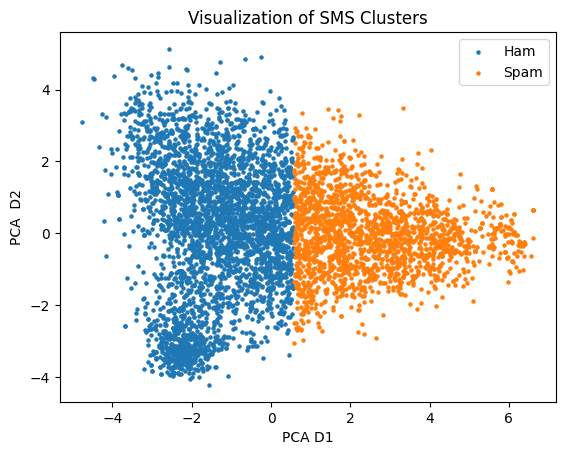

In [ ]:
ham_indices = df[df['cluster'] == 0].index
spam_indices = df[df['cluster'] == 1].index
import matplotlib.pyplot as plt


plt.scatter(reduced_embeddings[ham_indices, 0], reduced_embeddings[ham_indices, 1], label='Ham', cmap='viridis', s=5)
plt.scatter(reduced_embeddings[spam_indices, 0], reduced_embeddings[spam_indices, 1], label='Spam', cmap='viridis', s=5)

plt.title('Visualization of SMS Clusters')
plt.legend()
plt.xlabel('PCA D1')
plt.ylabel('PCA  D2')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score,classification_report

accuracy=accuracy_score(df['label_num'],df['cluster'])
report=classification_report(df['label_num'], df['cluster'])

print(f'Accuracy: {accuracy}\nClassification Report:\n{report}')


Accuracy: 0.5114860014357502
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.59      0.68      4825
           1       0.00      0.01      0.01       747

    accuracy                           0.51      5572
   macro avg       0.40      0.30      0.34      5572
weighted avg       0.69      0.51      0.59      5572

